In [1]:
# Set of import statements 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uproot
import glob
import os

2025-03-23 16:47:34.105965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 16:47:34.120791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-23 16:47:34.137608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-23 16:47:34.142591: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 16:47:34.156073: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from tqdm import tqdm

def generate_3D_data_from_folder(folder_path, tree_name="photon_sim", bins=(100, 100, 100)):
    """
    Extracts all events from all ROOT files in the given folder and returns a list of 3D histograms.
    
    Parameters:
    - folder_path: str, path to the folder containing ROOT files
    - tree_name: str, name of the tree inside the ROOT file
    - bins: tuple, number of bins in (x, y, z) dimensions
    
    Returns:
    - all_events: list of tuples [(X, Y, Z, values, E0) for each event in all files]
    """
    all_events = []
    file_list = glob.glob(os.path.join(folder_path, "*99.root"))

    for file_path in tqdm(file_list):
        with uproot.open(f"{file_path}:{tree_name}") as file:
            x = file["x"].array(library="np")
            y = file["y"].array(library="np")
            z = file["z"].array(library="np")
            dE = file["dE"].array(library="np")
            evt = file["EventID"].array(library="np")
            E0 = file["primaryE"].array(library="np")

        unique_events = np.unique(evt)
        for event_id in unique_events:
            mask = evt == event_id
            H3 = np.histogramdd(
                (x[mask], y[mask], z[mask]), bins=bins, weights=dE[mask]
            )
            edges_x, edges_y, edges_z = H3[1]

            # Compute bin centers
            x_centers = (edges_x[:-1] + edges_x[1:]) / 2
            y_centers = (edges_y[:-1] + edges_y[1:]) / 2
            z_centers = (edges_z[:-1] + edges_z[1:]) / 2

            # Flatten grid and values
            X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")
            X, Y, Z, values = X.flatten(), Y.flatten(), Z.flatten(), H3[0].flatten()

            all_events.append((X, Z, values, E0[event_id]))

    return all_events

# Example usage
data_list = generate_3D_data_from_folder("/media/disk/g4_showers/unif/")


100%|██████████| 1/1 [00:23<00:00, 23.33s/it]


Total deposited energy: 141904.796875
Total deposited energy after cut: 141904.71875


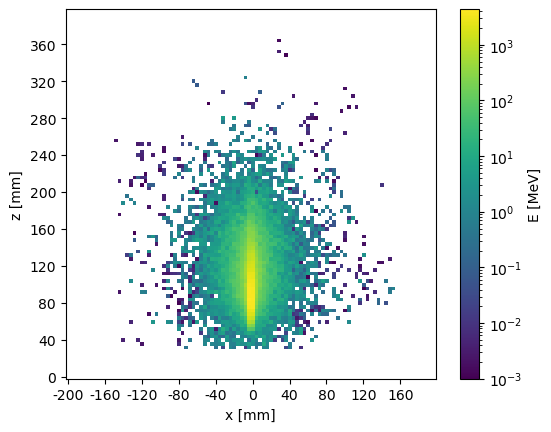

In [38]:
import tensorflow as tf
import matplotlib.colors as colors

lambda_reg = 1e-3  # Regularization strength

# Input marginal distribution f_Y(y, z)
evt = data_list[0]
deposits = evt[2].reshape(100,100,100)  # Stack x and z coordinates
f_Y = tf.cast(tf.reduce_sum(deposits, axis=0), tf.float32)  # Sum over x-axis

# Print total deposited energy
tot_depo = tf.reduce_sum(f_Y).numpy()
print(f"Total deposited energy: {tot_depo}")

f_Y = tf.where(f_Y > 1e-3, f_Y, 0)  

# Print deposit after cut
print(f"Total deposited energy after cut: {tf.reduce_sum(f_Y).numpy()}")

def plot_marginal(f_Y, vmin=1e-3):
    """
    Plot the marginal distribution f_Y(y, z).
    
    Parameters:
    - f_Y: tf.Tensor, shape (100, 100), marginal distribution f_Y(y, z)
    """
    plt.imshow(f_Y.numpy().T, origin='lower', norm=colors.LogNorm(vmin=vmin))
    plt.xticks(np.arange(0, 100, 10), np.arange(-200, 200, 40))
    plt.yticks(np.arange(0, 100, 10), np.arange(0, 400, 40))
    plt.xlabel('x [mm]')
    plt.ylabel('z [mm]')
    plt.colorbar(label='E [MeV]')
    plt.show()

plot_marginal(f_Y)

In [23]:
# Precomputed fraction matrix from `compute_ring_fractions`
def compute_ring_fractions(grid_size=100, num_samples=1000):
    fractions = np.zeros((grid_size, grid_size, grid_size//2), dtype=np.float32)

    x_vals = np.linspace(-grid_size/2 + 0.5, grid_size/2 - 0.5, grid_size)
    y_vals = np.linspace(-grid_size/2 + 0.5, grid_size/2 - 0.5, grid_size)

    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            xs = x + (np.random.rand(num_samples) - 0.5)
            ys = y + (np.random.rand(num_samples) - 0.5)
            rs = np.sqrt(xs**2 + ys**2)

            for r in range(1, grid_size//2):
                fractions[i, j, r] = np.mean((r-1 <= rs) & (rs < r))
    
    return fractions

fractions = compute_ring_fractions()
fractions = tf.convert_to_tensor(fractions)

In [30]:
# Generalize for 3D. adding z. Fractions was (100,100,50) but stays the same through z

r = tf.linspace(0, 50, 50)
x = tf.linspace(0, 100, 100)

# X, R = tf.cast(tf.meshgrid(x, r), tf.float32)
g_rz = tf.zeros([50,100])#tf.reduce_sum(f_Y)*tf.exp(-R**2/50)/tf.reduce_sum(tf.exp(-R**2/50))

g_rz = tf.Variable(g_rz, trainable=True, dtype=tf.float32)

@tf.function
def model_loss(g_rz, fractions, I_target):
    I_pred = tf.einsum('rz,xyr->xz', g_rz, fractions)
    return tf.reduce_mean(tf.square(I_pred - I_target))

@tf.function
def train_step(g_rz, fractions, E, optimizer):
    with tf.GradientTape() as tape:
        loss = model_loss(g_rz, fractions, E)
    grads = tape.gradient(loss, [g_rz])
    optimizer.apply_gradients(zip(grads, [g_rz]))
    # clamp negative values to zero
    g_rz.assign(tf.maximum(g_rz, 0))
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
num_iterations = 30000
for i in range(num_iterations):
    loss_val = train_step(g_rz, fractions, f_Y, optimizer)
    if i % 100 == 0:
        print(f"Iteration {i}: Loss = {loss_val.numpy()}")

Iteration 0: Loss = 31386.662109375
Iteration 100: Loss = 26903.712890625
Iteration 200: Loss = 25205.90234375
Iteration 300: Loss = 23955.359375
Iteration 400: Loss = 22935.12109375
Iteration 500: Loss = 22061.25390625
Iteration 600: Loss = 21290.751953125
Iteration 700: Loss = 20598.162109375
Iteration 800: Loss = 19966.955078125
Iteration 900: Loss = 19385.666015625
Iteration 1000: Loss = 18845.970703125
Iteration 1100: Loss = 18341.6171875
Iteration 1200: Loss = 17867.734375
Iteration 1300: Loss = 17420.4609375
Iteration 1400: Loss = 16996.685546875
Iteration 1500: Loss = 16593.81640625
Iteration 1600: Loss = 16209.716796875
Iteration 1700: Loss = 15842.5537109375
Iteration 1800: Loss = 15490.802734375
Iteration 1900: Loss = 15153.1357421875
Iteration 2000: Loss = 14828.333984375
Iteration 2100: Loss = 14515.373046875
Iteration 2200: Loss = 14213.3662109375
Iteration 2300: Loss = 13921.533203125
Iteration 2400: Loss = 13639.1884765625
Iteration 2500: Loss = 13365.7236328125
Iterati

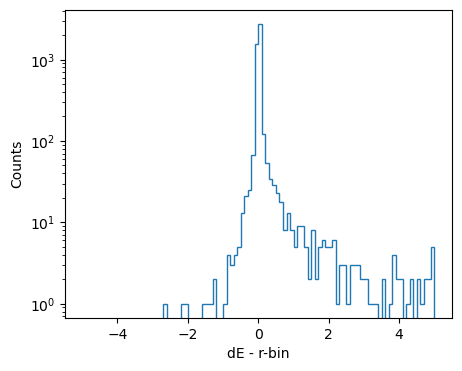

In [29]:
# Plot the distribution of bin deposits
plt.figure(figsize=(5, 4))
plt.hist(g_rz.numpy().flatten(), bins=100, range=(-5,5), histtype='step');
plt.yscale('log')
plt.xlabel('dE - r-bin')
plt.ylabel('Counts')
plt.show()

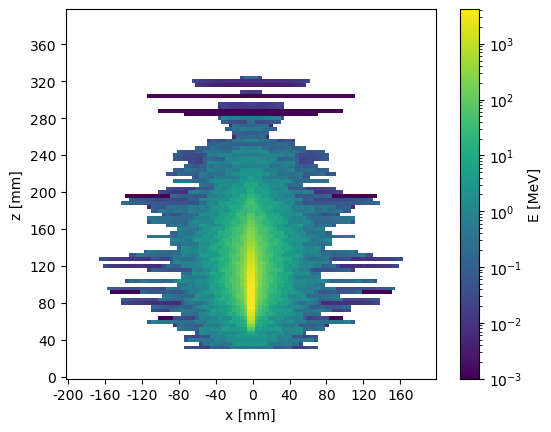

In [39]:
# Cut off small values
g_rz_pred = g_rz #tf.where(g_rz > 0, g_rz, 0)
# Check the marginal
I_pred = tf.einsum('xyr,rz->xz', fractions, g_rz_pred)

plot_marginal(I_pred)

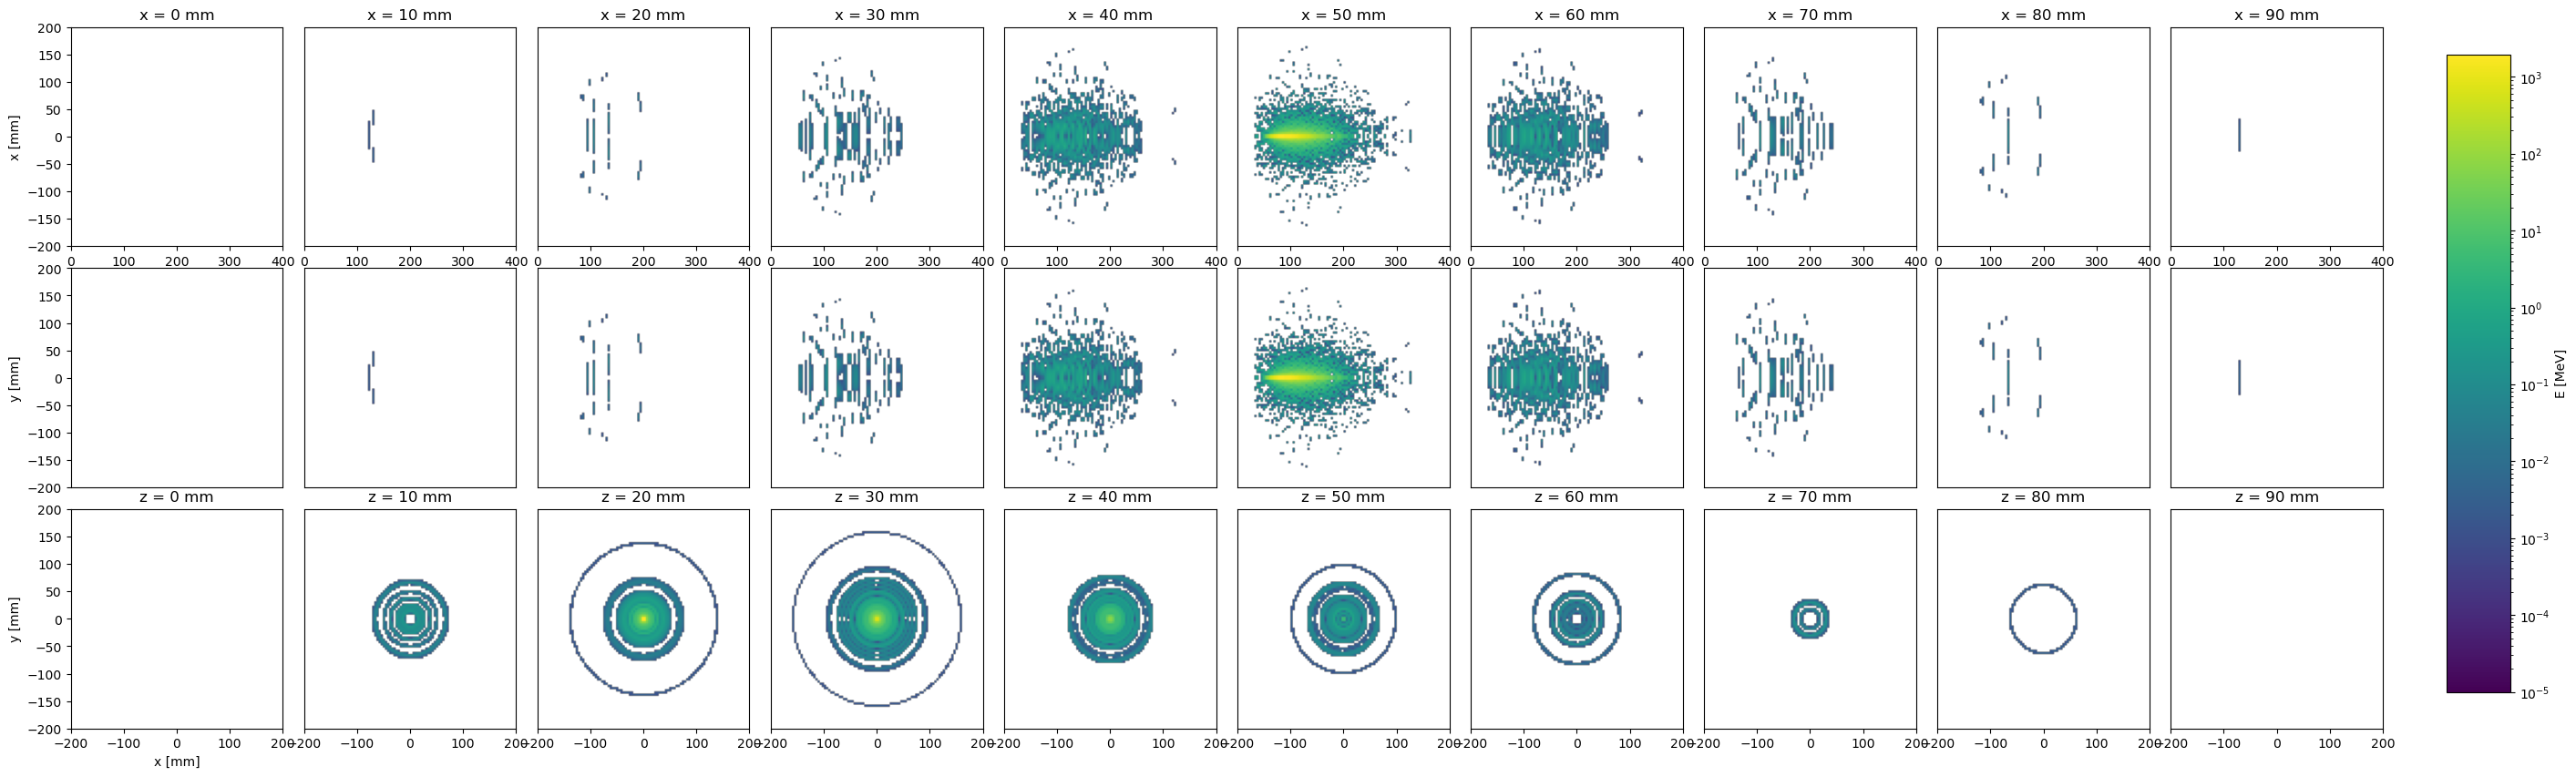

In [121]:
E_pred = tf.einsum('rz,xyr->xyz', g_rz_pred, fractions)
E_pred = tf.where(E_pred > 1e-3, E_pred, 0)

fig, axs = plt.subplots(3, 10, figsize=(35, 10))  

# Use same color scale for all plots
vmin = np.min(E_pred) + 1e-5
vmax = np.max(E_pred)

for i in range(10):
    # XZ slices (first row)
    im = axs[0, i].imshow(E_pred[i * 10, :, :], origin='upper',
                           norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                           extent=[0, 400, -200, 200], aspect='auto')

    # YZ slices (second row)
    axs[1, i].imshow(E_pred[:, i * 10, :], origin='upper',
                      norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                      extent=[0, 400, -200, 200], aspect='auto')

    # XY slices (third row)
    axs[2, i].imshow(E_pred[:, :, i * 10], origin='upper',
                      norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                      extent=[-200, 200, -200, 200], aspect='auto')

    # Axis labels and ticks
    if i == 0:
        axs[0, i].set_ylabel('x [mm]')
        axs[1, i].set_ylabel('y [mm]')
        axs[2, i].set_ylabel('y [mm]')
        axs[2, i].set_xlabel('x [mm]')
    else:
        axs[0, i].set_yticks([])
        axs[1, i].set_yticks([])
        axs[2, i].set_yticks([])
    
    # Remove x ticks on central row (YZ slices)
    axs[1, i].set_xticks([])

    # Show z-axis labels only on first row
    if i == 0:
        axs[0, i].set_xlabel('z [mm]')

    # Titles for clarity
    axs[0, i].set_title(f"x = {i*10} mm")
    axs[2, i].set_title(f"z = {i*10} mm")

# Adjust layout manually to make space for colorbar
fig.subplots_adjust(right=0.85, wspace=0.1, hspace=0.1)  # No warning now

# Add colorbar outside the plot
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # Corrected placement
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('E [MeV]')

plt.show()


In [33]:
# Check energy conservation 
E_pred_sum = tf.reduce_sum(E_pred, axis=(0,1,2))
print(E_pred_sum)
print(tf.reduce_sum(f_Y))

tf.Tensor(141972.2, shape=(), dtype=float32)
tf.Tensor(141904.72, shape=(), dtype=float32)


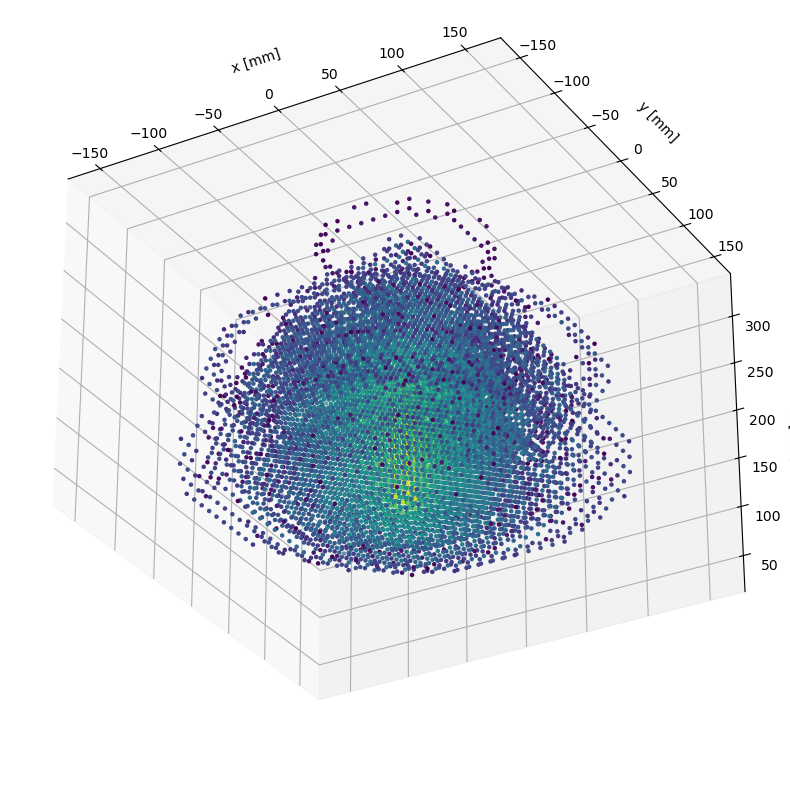

In [88]:
# Get a 3D render of the energy deposition E_pred
from mpl_toolkits.mplot3d import Axes3D

def plot_3D(E_pred, vmin=1e-3):
    """
    Plot the 3D energy deposition E_pred(x, y, z).
    
    Parameters:
    - E_pred: tf.Tensor, shape (100, 100, 100), energy deposition E_pred(x, y, z)
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(-200, 200, 100)
    y = np.linspace(-200, 200, 100)
    z = np.linspace(0, 400, 100)
    _X, _Y, _Z = np.meshgrid(x, y, z)
    H = np.histogramdd((_X.flatten(), _Y.flatten(), _Z.flatten()), bins=(40, 40, 40), weights=E_pred.numpy().flatten())
    values = H[0].flatten()
    edges_x, edges_y, edges_z = H[1]
    centers_x = (edges_x[:-1] + edges_x[1:]) / 2
    centers_y = (edges_y[:-1] + edges_y[1:]) / 2
    centers_z = (edges_z[:-1] + edges_z[1:]) / 2
    X, Y, Z = np.meshgrid(centers_x, centers_y, centers_z, indexing="ij")
    alphas = 1 - (values / np.max(values))**4
    mask = values > vmin
    ax.scatter(X.flatten()[mask], Y.flatten()[mask], Z.flatten()[mask], c=values[mask], alpha=alphas[mask], cmap='viridis', s=5, norm=colors.LogNorm()) 
    ax.set_xlabel('x [mm]')
    ax.set_ylabel('y [mm]')
    ax.set_zlabel('z [mm]')
    # Get current azimuth and elevation
    azim = ax.azim
    elev = ax.elev
    ax.view_init(elev=elev-60, azim=azim)
    plt.show()

plot_3D(E_pred)

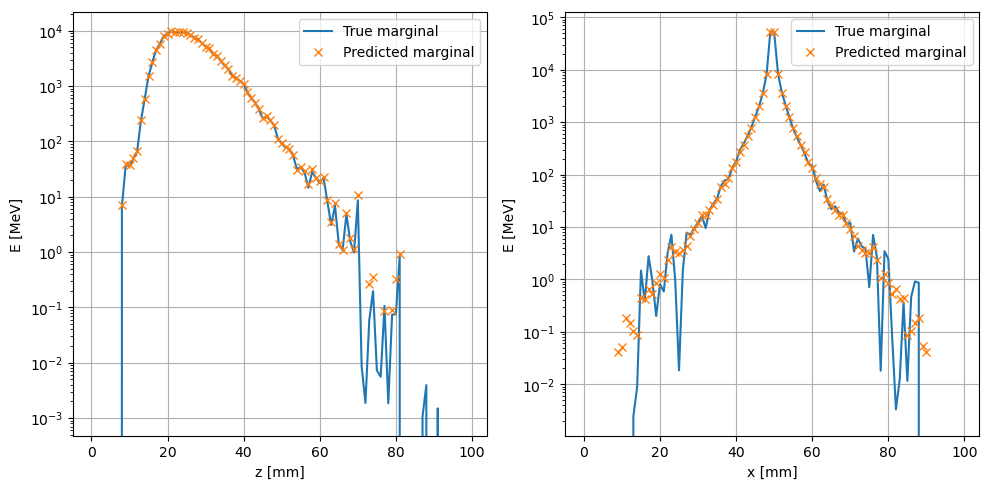

In [98]:
# Compare deposited energy vs x and vs z for marginal and predicted. Plot residuals as well
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.plot(tf.reduce_sum(f_Y, axis=0), label='True marginal')
ax1.plot(tf.reduce_sum(E_pred, axis=(0,1)), label='Predicted marginal', marker='x', linestyle='none')
ax1.set_xlabel('z [mm]')
ax1.set_ylabel('E [MeV]')
ax1.set_yscale('log')
ax1.grid()
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(tf.reduce_sum(f_Y, axis=1), label='True marginal')
ax2.plot(tf.reduce_sum(E_pred, axis=(0,2)), label='Predicted marginal', marker='x', linestyle='none')
ax2.set_xlabel('x [mm]')
ax2.set_ylabel('E [MeV]')
ax2.set_yscale('log')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()

In [3]:
def generate_data_from_folder(folder_path, tree_name="photon_sim", bins=(100, 100, 100)):
    """
    Extracts all events from all ROOT files in the given folder and returns a list of 3D histograms.
    
    Parameters:
    - folder_path: str, path to the folder containing ROOT files
    - tree_name: str, name of the tree inside the ROOT file
    - bins: tuple, number of bins in (x, y, z) dimensions
    
    Returns:
    - all_events: list of tuples [(X, Y, Z, values, E0) for each event in all files]
    """
    all_events = []
    file_list = glob.glob(os.path.join(folder_path, "*99.root"))

    for file_path in tqdm(file_list):
        with uproot.open(f"{file_path}:{tree_name}") as file:
            x = file["x"].array(library="np")
            y = file["y"].array(library="np")
            z = file["z"].array(library="np")
            dE = file["dE"].array(library="np")
            evt = file["EventID"].array(library="np")
            E0 = file["primaryE"].array(library="np")

        unique_events = np.unique(evt)
        for event_id in unique_events:
            mask = evt == event_id
            H3 = np.histogramdd(
                (x[mask], y[mask], z[mask]), bins=bins, weights=dE[mask]
            )
            edges_x, edges_y, edges_z = H3[1]

            # Compute bin centers
            x_centers = (edges_x[:-1] + edges_x[1:]) / 2
            y_centers = (edges_y[:-1] + edges_y[1:]) / 2
            z_centers = (edges_z[:-1] + edges_z[1:]) / 2

            # Flatten grid and values
            X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing="ij")
            X, Y, Z, values = X.flatten(), Y.flatten(), Z.flatten(), H3[0].flatten()

            all_events.append((X, Y, Z, values))

    return all_events

# Example usage
new_list = generate_data_from_folder("/media/disk/g4_showers/unif/")

100%|██████████| 1/1 [00:24<00:00, 24.59s/it]


In [ ]:



# Create an instance of the model
model = EnergyDepositionModel()

# Example usage
data = new_list[0]
f_Y = tf.cast(tf.reduce_sum(data[3].reshape(100,100,100), axis=0), tf.float32)
E_pred = model(f_Y)


Inflating shower: 100%|██████████| 25000/25000 [00:14<00:00, 1686.07it/s]
